# Human Activity Recognition using TSFEL

On this example, we will perform Human Activity Recognition using our library **Time Series Feature Extraction Library**.

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists of importing the library. To do that press play. 

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [5]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.3.tar.gz >/dev/null 2>&1
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1

O sistema nÆo conseguiu localizar o caminho especificado.
O sistema nÆo conseguiu localizar o caminho especificado.


To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If UCI HAR Dataset folder does not appear run Import Time Series Features library again.

---


In [2]:
# Import libraries
import tsfel
import glob
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

# Unzip dataset
zip_ref = zipfile.ZipFile("UCI HAR Dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

# Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

The dataset used in this example can be found [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).




In [110]:
#@title Data Preparation
# Load train and test signals
train_files = glob.glob("UCI HAR Dataset/train/Inertial Signals/*.txt")
test_files = glob.glob("UCI HAR Dataset/test/Inertial Signals/*.txt")

strain = np.vstack([[np.loadtxt(fl).T] for fl in train_files if 'body_acc' not in fl]).T
stest = np.vstack([[np.loadtxt(fl).T] for fl in test_files if 'body_acc' not in fl]).T

columns_names_train = [fl.split('_')[-3] + fl.split('_')[-2] for fl in train_files if 'body_acc' not in fl]
columns_names_test  = [fl.split('_')[-3] + fl.split('_')[-2] for fl in test_files if 'body_acc' not in fl]

x_train_sig = [pd.DataFrame(strain[i], columns=columns_names_train) for i in range(len(strain))]
x_test_sig = [pd.DataFrame(stest[i], columns=columns_names_test) for i in range(len(stest))]

y_test = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
y_train = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
activity_labels = np.array(pd.read_csv('UCI HAR Dataset/activity_labels.txt', header=None, delimiter=' '))[:,1]

# dataset sampling frequency
fs = 100

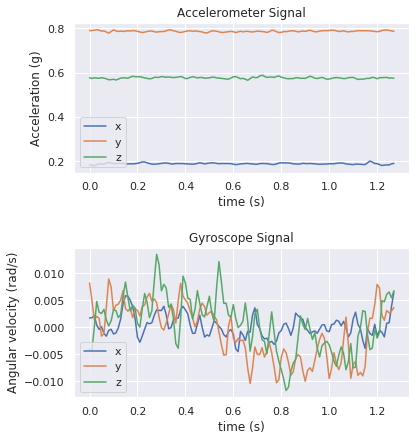

In [111]:
#@Signal Preview
%matplotlib inline

window_number = 60
plot_axis = ['x', 'y', 'z']

plt.figure()
plt.subplot(2,1,1)
[plt.plot(np.arange(len(x_train_sig[window_number]))/fs, x_train_sig[window_number]['acc' + ax]) for ax in plot_axis]
plt.xlabel("time (s)")
plt.ylabel("Acceleration (g)")
plt.title("Accelerometer Signal")
plt.legend(plot_axis)

plt.subplot(2,1,2)
[plt.plot(np.arange(len(x_train_sig[window_number]))/fs, x_train_sig[window_number]['gyro' + ax]) for ax in plot_axis]
plt.xlabel("time (s)")
plt.ylabel("Angular velocity (rad/s)")
plt.title("Gyroscope Signal")
plt.legend(plot_axis)
plt.subplots_adjust(left=None, bottom=-0.3, right=None, top=1, wspace=None, hspace=0.5)

plt.show()

# Feature Extraction

Through **Feature Extraction** methodologies, the data is translated into a feature vector containing information about the signal properties of each window. These properties can be classified according to their domain as Time, Frequency and Statistical features and allow to characterise the signal compactly, enhancing its characteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/13u7L_5IX3XxFuq_SnbOZF1dXQfcBB0wR3PXhvevhPYA/edit?usp=sharing). Save a copy on your local drive and share it with featext@featext.iam.gserviceaccount.com.

**Change your google sheet file name and the googleSheet_name variable to your name so both have the same name.**

In [62]:
#@title Feature Extraction
googleSheet_name = "Features_dev"
# Extract excel info
cfg_file = tsfel.extract_sheet(googleSheet_name)

# Get features
X_train = tsfel.time_series_features_extractor(cfg_file, x_train_sig, fs=fs)
X_test = tsfel.time_series_features_extractor(cfg_file, x_test_sig, fs=fs)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [104]:
# Handling eventual missing values from the feature extraction
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
features = pd.concat([X_train, X_test])
for rej in corr_features:
    features = features.drop(rej, axis=1)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

# Normalising Features
min_max_scaler = preprocessing.MinMaxScaler()
nX_train = pd.DataFrame(min_max_scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
nX_test = pd.DataFrame(min_max_scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

In [107]:
classifier = RandomForestClassifier()

# Train the classifier
classifier.fit(nX_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) * 100
print(classification_report(y_test, y_test_predict))
print("Accuracy: " + str(accuracy) + '%')

              precision    recall  f1-score   support

         1.0       0.89      0.94      0.91       496
         2.0       0.92      0.93      0.93       471
         3.0       0.90      0.83      0.86       420
         4.0       0.90      0.90      0.90       491
         5.0       0.91      0.90      0.91       532
         6.0       1.00      1.00      1.00       537

   micro avg       0.92      0.92      0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947

Accuracy: 92.02578893790296%


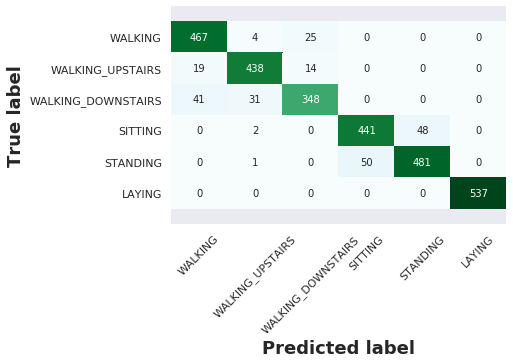

In [108]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.